In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
import precision_recall_cutoff

## Defining the bucket 
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the csv file 
file_key = 'In_Class_Assignments/turnover.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
turnover = pd.read_csv(file_content_stream)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
## Changing sales to dummy variables
turnover = pd.concat([turnover.drop(columns = ['sales'], axis = 1), pd.get_dummies(turnover['sales'])], axis = 1)

## Changing salary to dummy variables
turnover = pd.concat([turnover, pd.get_dummies(turnover['salary'])], axis = 1)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0


In [3]:
## Creating interactions/features from the decision tree
turnover['interaction_1'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] <= 2.5) & (turnover['last_evaluation'] <= 0.575), 1, 0)
turnover['interaction_2'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] >= 2.5) & (turnover['satisfaction_level'] >= 0.115), 1, 0)
turnover['interaction_3'] = np.where((turnover['satisfaction_level'] >= 0.465) & (turnover['time_spend_company'] <= 4.5) & (turnover['average_montly_hours'] <= 290.5), 1, 0)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium,interaction_1,interaction_2,interaction_3
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0


In [4]:
## Defining the input and target variables
X = turnover.drop(columns = ['left', 'salary'], axis = 1)
Y = turnover['left']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [5]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium,interaction_1,interaction_2,interaction_3
8372,0.36,0.56,6,242,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
8431,0.55,0.55,5,194,3,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
5146,0.75,0.53,4,251,3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
7439,0.96,0.61,4,158,6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
11496,0.31,0.86,3,266,7,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0


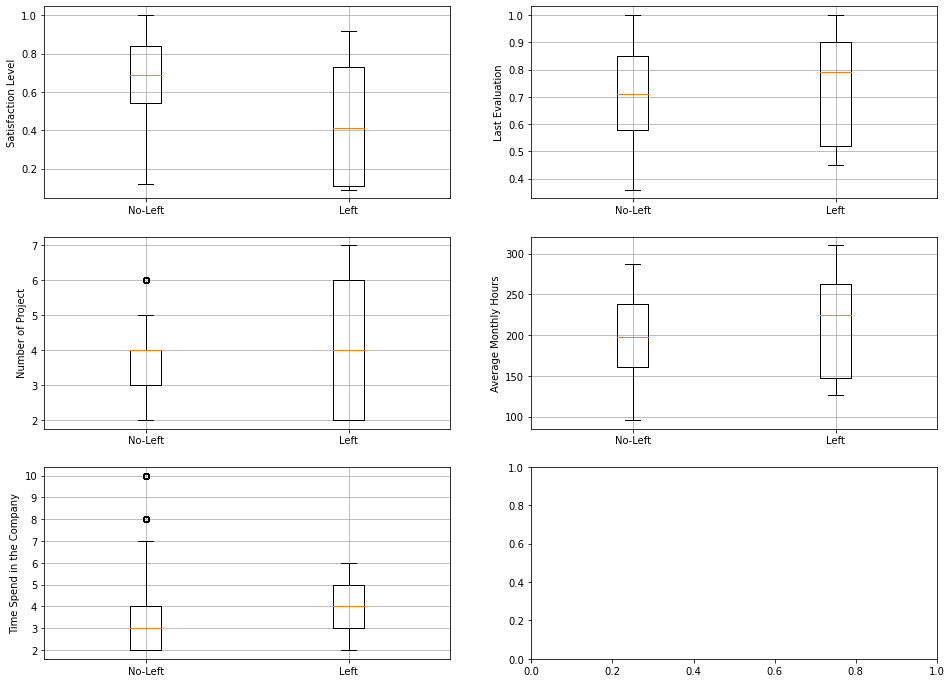

In [6]:
turnover_train = pd.concat([X_train, Y_train], axis = 1)

## Creating a new figure
fig, axes = plt.subplots(3, 2, figsize = (16, 12))

## Subsetting the data 
left = turnover_train[turnover_train['left'] == 1]
no_left = turnover_train[turnover_train['left'] == 0]

axes[0, 0].boxplot([no_left['satisfaction_level'], left['satisfaction_level']], labels = ['No-Left', 'Left'])
axes[0, 0].set_ylabel('Satisfaction Level')
axes[0, 0].grid()

axes[0, 1].boxplot([no_left['last_evaluation'], left['last_evaluation']], labels = ['No-Left', 'Left'])
axes[0, 1].set_ylabel('Last Evaluation')
axes[0, 1].grid()

axes[1, 0].boxplot([no_left['number_project'], left['number_project']], labels = ['No-Left', 'Left'])
axes[1, 0].set_ylabel('Number of Project')
axes[1, 0].grid()

axes[1, 1].boxplot([no_left['average_montly_hours'], left['average_montly_hours']], labels = ['No-Left', 'Left'])
axes[1, 1].set_ylabel('Average Monthly Hours')
axes[1, 1].grid()

axes[2, 0].boxplot([no_left['time_spend_company'], left['time_spend_company']], labels = ['No-Left', 'Left'])
axes[2, 0].set_ylabel('Time Spend in the Company')
axes[2, 0].grid()

In [7]:
pd.crosstab(turnover_train['Work_accident'], turnover_train['left'], normalize = 'index')

left,0,1
Work_accident,,
0,0.734569,0.265431
1,0.922592,0.077408


In [8]:
pd.crosstab(turnover_train['promotion_last_5years'], turnover_train['left'], normalize = 'index')

left,0,1
promotion_last_5years,,
0,0.757715,0.242285
1,0.944238,0.055762


In [9]:
pd.crosstab(turnover_train['IT'], turnover_train['left'], normalize = 'index')

left,0,1
IT,,
0,0.760658,0.239342
1,0.775551,0.224449


In [10]:
pd.crosstab(turnover_train['RandD'], turnover_train['left'], normalize = 'index')

left,0,1
RandD,,
0,0.757317,0.242683
1,0.845659,0.154341


In [11]:
pd.crosstab(turnover_train['accounting'], turnover_train['left'], normalize = 'index')

left,0,1
accounting,,
0,0.763526,0.236474
1,0.732595,0.267405


In [12]:
pd.crosstab(turnover_train['hr'], turnover_train['left'], normalize = 'index')

left,0,1
hr,,
0,0.764706,0.235294
1,0.706087,0.293913


In [13]:
pd.crosstab(turnover_train['management'], turnover_train['left'], normalize = 'index')

left,0,1
management,,
0,0.757763,0.242237
1,0.856574,0.143426


In [14]:
pd.crosstab(turnover_train['marketing'], turnover_train['left'], normalize = 'index')

left,0,1
marketing,,
0,0.761434,0.238566
1,0.769688,0.230312


In [15]:
pd.crosstab(turnover_train['product_mng'], turnover_train['left'], normalize = 'index')

left,0,1
product_mng,,
0,0.760430,0.239570
1,0.784447,0.215553


In [16]:
pd.crosstab(turnover_train['sales'], turnover_train['left'], normalize = 'index')

left,0,1
sales,,
0,0.764455,0.235545
1,0.755200,0.244800


In [17]:
pd.crosstab(turnover_train['support'], turnover_train['left'], normalize = 'index')

left,0,1
support,,
0,0.763642,0.236358
1,0.751833,0.248167


In [18]:
pd.crosstab(turnover_train['technical'], turnover_train['left'], normalize = 'index')

left,0,1
technical,,
0,0.766412,0.233588
1,0.741490,0.258510


In [19]:
pd.crosstab(turnover_train['high'], turnover_train['left'], normalize = 'index')

left,0,1
high,,
0,0.746866,0.253134
1,0.929221,0.070779


In [20]:
pd.crosstab(turnover_train['low'], turnover_train['left'], normalize = 'index')

left,0,1
low,,
0,0.819118,0.180882
1,0.702330,0.297670


In [21]:
pd.crosstab(turnover_train['medium'], turnover_train['left'], normalize = 'index')

left,0,1
medium,,
0,0.735003,0.264997
1,0.797895,0.202105


In [22]:
pd.crosstab(turnover_train['interaction_1'], turnover_train['left'], normalize = 'index')

left,0,1
interaction_1,,
0,0.845788,0.154212
1,0.059375,0.940625


In [23]:
pd.crosstab(turnover_train['interaction_2'], turnover_train['left'], normalize = 'index')

left,0,1
interaction_2,,
0,0.743706,0.256294
1,0.920583,0.079417


In [24]:
pd.crosstab(turnover_train['interaction_3'], turnover_train['left'], normalize = 'index')

left,0,1
interaction_3,,
0,0.438593,0.561407
1,0.986443,0.013557


In [25]:
## Defining the input and target variables
X_train = X_train[['satisfaction_level', 'average_montly_hours', 'time_spend_company', 
                   'high', 'interaction_1', 'interaction_2', 'interaction_3']]
X_test = X_test[['satisfaction_level', 'average_montly_hours', 'time_spend_company', 
                 'high', 'interaction_1', 'interaction_2', 'interaction_3']]
                 
## Random forest with top 7
RF = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on test
RF_pred = RF.predict_proba(X_test)[:, 1]

## Predicting the labels
RF_labels = precision_recall_cutoff.precision_recall_cutoff(Y_test, RF_pred)

## Computing the classification report
print(classification_report(Y_test, RF_labels))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2286
           1       0.91      0.92      0.91       714

    accuracy                           0.96      3000
   macro avg       0.94      0.95      0.94      3000
weighted avg       0.96      0.96      0.96      3000



In [26]:
## AdaBoost model 
Ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), 
                         n_estimators = 500, 
                         learning_rate = 0.01).fit(X_train, Y_train)

## Predicting on test
Ada_pred = Ada.predict_proba(X_test)[:, 1]

## Predicting the labels
Ada_labels = precision_recall_cutoff.precision_recall_cutoff(Y_test, Ada_pred)

## Computing the classification report
print(classification_report(Y_test, Ada_labels))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2286
           1       0.97      0.92      0.94       714

    accuracy                           0.97      3000
   macro avg       0.97      0.95      0.96      3000
weighted avg       0.97      0.97      0.97      3000



In [28]:
## Based on my results, I would use the AdaBoost model to predict \texttt{left}.